In [1]:
import cv2
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
# from scipy import ndimage, signal
import skimage
from sklearn import cluster

In [2]:
np.set_printoptions(threshold=20, edgeitems=10, linewidth=140, precision=3, suppress=True)

In [3]:
matplotlib.rcParams['figure.figsize'] = 8, 6
matplotlib.rcParams['figure.figsize'], matplotlib.rcParams['figure.dpi']

([8.0, 6.0], 72.0)

In [4]:
rgb = cv2.imread('./data/robot.bmp')[..., ::-1]
rgb = rgb / 255
rgb.shape, rgb.dtype

((234, 160, 3), dtype('float64'))

In [5]:
gray = cv2.cvtColor(rgb.astype(np.float32), cv2.COLOR_RGB2GRAY)
gray.shape

(234, 160)

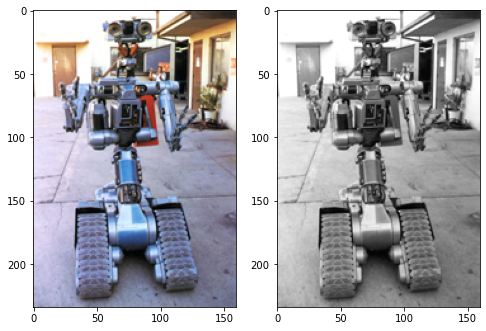

In [6]:
plt.subplot(1, 2, 1)
plt.imshow(rgb);
plt.subplot(1, 2, 2)
plt.imshow(gray, cmap='gray', vmin=0, vmax=1);

# Edges as gradient

## First some simple 1D example

In [7]:
t = np.linspace(-3., 3., 61)  # e.g. time
x = np.exp(-t**2)  # value of function in time
x.shape, x.dtype

((61,), dtype('float64'))

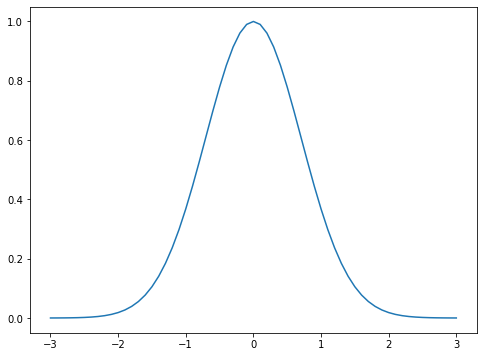

In [8]:
plt.plot(t, x);

In [9]:
dx = np.zeros_like(x)
dx.shape, dx.dtype

((61,), dtype('float64'))

In [10]:
x[:-1]

array([0.   , 0.   , 0.   , 0.001, 0.001, 0.002, 0.003, 0.005, 0.008, 0.012, ..., 0.018, 0.012, 0.008, 0.005, 0.003, 0.002, 0.001, 0.001,
       0.   , 0.   ])

In [11]:
x[1:]

array([0.   , 0.   , 0.001, 0.001, 0.002, 0.003, 0.005, 0.008, 0.012, 0.018, ..., 0.012, 0.008, 0.005, 0.003, 0.002, 0.001, 0.001, 0.   ,
       0.   , 0.   ])

In [12]:
# dx[1] = x[1] - x[0]
# dx[2] = x[2] - x[1]
dx = x[1:] - x[:-1]
dx

array([ 0.   ,  0.   ,  0.   ,  0.   ,  0.001,  0.001,  0.002,  0.003,  0.004,  0.006, ..., -0.006, -0.004, -0.003, -0.002, -0.001, -0.001,
       -0.   , -0.   , -0.   , -0.   ])

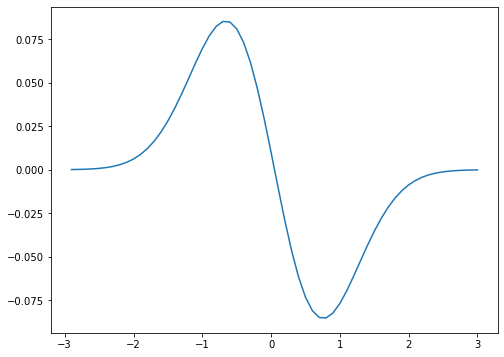

In [13]:
plt.plot(t[1:], dx);

## Asymmetric in 2D

In [14]:
dx_ = gray[:, 1:] - gray[:, :-1]
dy_ = gray[1:, :] - gray[:-1, :]
dx_.shape, dy_.shape

((234, 159), (233, 160))

In [15]:
gray.shape

(234, 160)

In [16]:
# same thing using built in function
dx = np.diff(gray, axis=1)
dy = np.diff(gray, axis=0)
dx.shape, dy.shape

((234, 159), (233, 160))

In [17]:
np.sum(np.abs(dx - dx_)), np.sum(np.abs(dy - dy_))

(0.0, 0.0)

In [18]:
# allows for handling borders
dx = np.diff(gray, axis=1, prepend=0)
dy = np.diff(gray, axis=0, prepend=0)
dx.shape, dy.shape

((234, 160), (234, 160))

In [19]:
mag = np.sqrt(dx ** 2 + dy ** 2)
mag.shape

(234, 160)

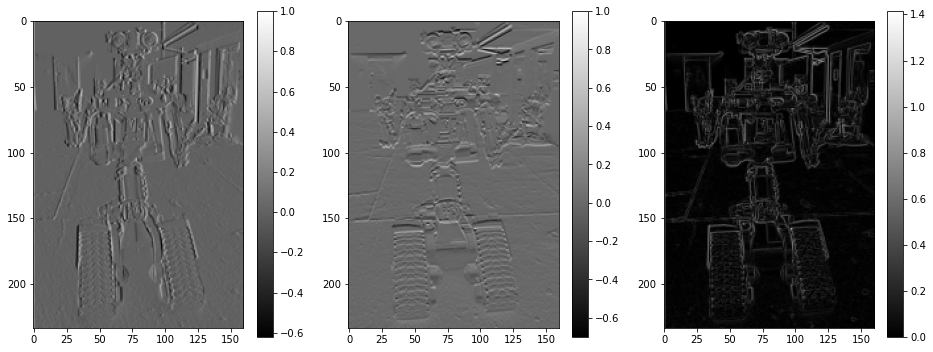

In [20]:
plt.figure(figsize=(16, 6))
for i, d in enumerate((dx, dy, mag)):
    plt.subplot(1, 3, i + 1)
    plt.imshow(d, cmap='gray')
    plt.colorbar();

## Symmetric in 2D

In [21]:
dx_ = (gray[:, 2:] - gray[:, :-2]) / 2
dy_ = (gray[2:, :] - gray[:-2, :]) / 2
dx_.shape, dy_.shape

((234, 158), (232, 160))

In [22]:
# symmetric
dy, dx = np.gradient(gray)
dx.shape, dy.shape

((234, 160), (234, 160))

In [23]:
mag = np.sqrt(dx ** 2 + dy ** 2)

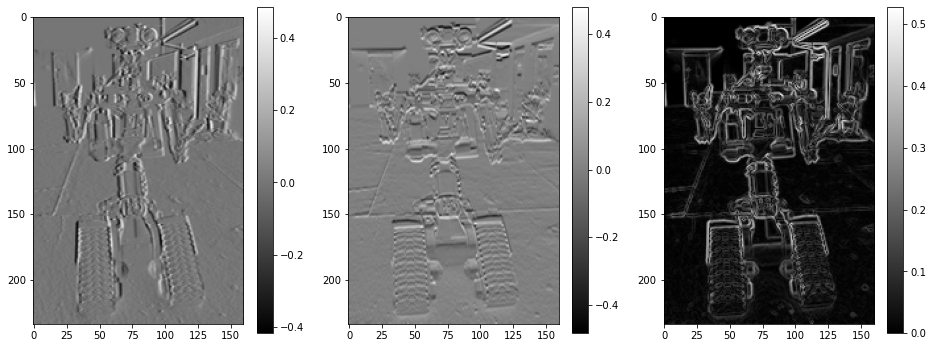

In [24]:
plt.figure(figsize=(16, 6))
for i, d in enumerate((dx, dy, mag)):
    plt.subplot(1, 3, i + 1)
    plt.imshow(d, cmap='gray')
    plt.colorbar();

# Edges via convolution

In [25]:
kernel_dx = np.array([
    [-1, 0, 1]
]) / 2.
kernel_dx

array([[-0.5,  0. ,  0.5]])

In [26]:
kernel_dy = kernel_dx.T
kernel_dy

array([[-0.5],
       [ 0. ],
       [ 0.5]])

In [27]:
dx_ = cv2.filter2D(gray, -1, kernel_dx)
dy_ = cv2.filter2D(gray, -1, kernel_dy)
mag_ = np.sqrt(dx_ ** 2 + dy_ ** 2)

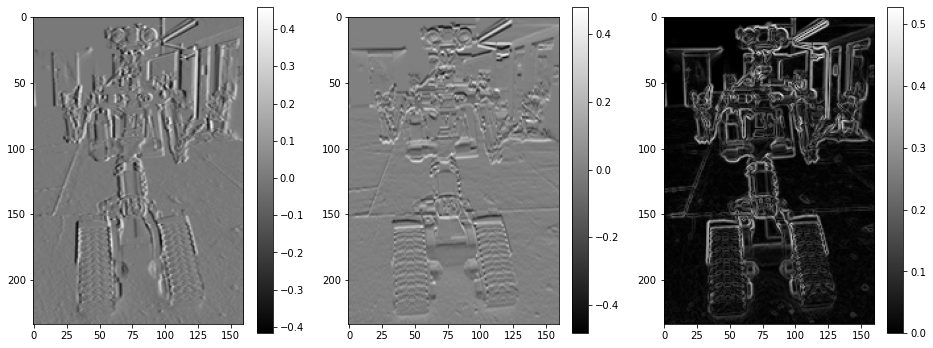

In [28]:
plt.figure(figsize=(16, 6))
for i, d in enumerate((dx_, dy_, mag_)):
    plt.subplot(1, 3, i + 1)
    plt.imshow(d, cmap='gray')
    plt.colorbar();

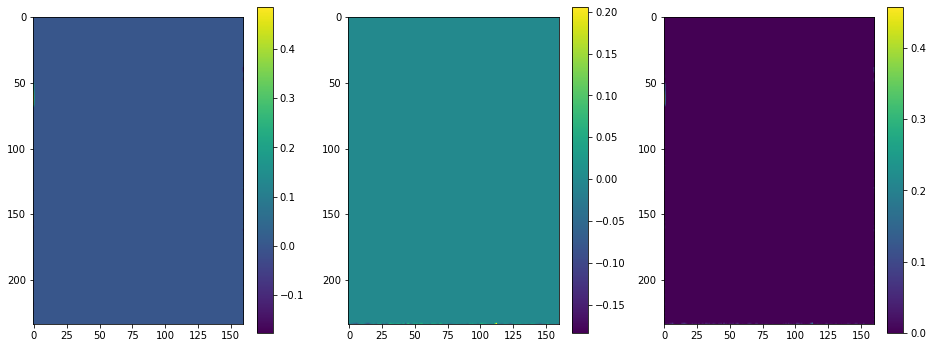

In [29]:
plt.figure(figsize=(16, 6))
for i, (d, d_) in enumerate(zip((dx, dy, mag), (dx_, dy_, mag_))):
    plt.subplot(1, 3, i + 1)
    plt.imshow(d - d_)
    plt.colorbar();

## Sobel as gradient

In [30]:
kernel_sob_x = np.array(
    [
        [-1, 0, 1],
        [-2, 0, 2],
        [-1, 0, 1]
    ],
    dtype=float
)
kernel_sob_x

array([[-1.,  0.,  1.],
       [-2.,  0.,  2.],
       [-1.,  0.,  1.]])

In [31]:
kernel_sob_y = kernel_sob_x.T
kernel_sob_y

array([[-1., -2., -1.],
       [ 0.,  0.,  0.],
       [ 1.,  2.,  1.]])

In [32]:
# as a convolution
dx = cv2.filter2D(gray, -1, kernel_sob_x)
dy = cv2.filter2D(gray, -1, kernel_sob_y)

In [33]:
# specialized function in OpenCV
dx_ = cv2.Sobel(gray, -1, 1, 0)
dy_ = cv2.Sobel(gray, -1, 0, 1)

In [34]:
np.sum(np.abs(dx - dx_)), np.sum(np.abs(dy - dy_))

(0.0009604851, 0.0034365375)

In [35]:
np.max(np.abs(dx - dx_) + np.abs(dy - dy_))

8.34465e-07

In [36]:
mag = np.sqrt(dx ** 2 + dy ** 2)

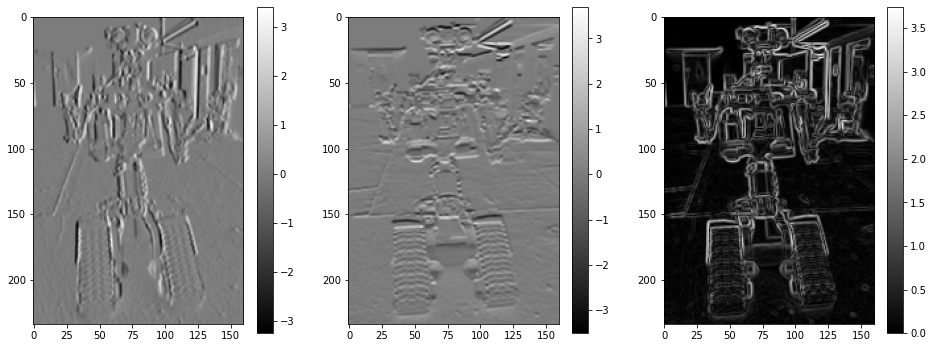

In [37]:
plt.figure(figsize=(16, 6))
for i, d in enumerate((dx, dy, mag)):
    plt.subplot(1, 3, i + 1)
    plt.imshow(d, cmap='gray')
    plt.colorbar();

## Directional Sobel

In [38]:
h = np.array([1, 2, 1, 0, -1, -2, -1, 0], dtype=float)
create_sob = lambda h: np.array([
    [h[0], h[1], h[2]],
    [h[7],    0, h[3]],
    [h[6], h[5], h[4]]
])
kernels_sob = np.array([create_sob(np.roll(h, r)) for r in range(8)])
kernels_sob

array([[[ 1.,  2.,  1.],
        [ 0.,  0.,  0.],
        [-1., -2., -1.]],

       [[ 0.,  1.,  2.],
        [-1.,  0.,  1.],
        [-2., -1.,  0.]],

       [[-1.,  0.,  1.],
        [-2.,  0.,  2.],
        [-1.,  0.,  1.]],

       [[-2., -1.,  0.],
        [-1.,  0.,  1.],
        [ 0.,  1.,  2.]],

       [[-1., -2., -1.],
        [ 0.,  0.,  0.],
        [ 1.,  2.,  1.]],

       [[ 0., -1., -2.],
        [ 1.,  0., -1.],
        [ 2.,  1.,  0.]],

       [[ 1.,  0., -1.],
        [ 2.,  0., -2.],
        [ 1.,  0., -1.]],

       [[ 2.,  1.,  0.],
        [ 1.,  0., -1.],
        [ 0., -1., -2.]]])

In [39]:
# convolve with all directional (compass) filters
edges_sob_dir = np.zeros(gray.shape + kernels_sob.shape[:1], dtype=gray.dtype)
for i, kern in enumerate(kernels_sob):
    edges_sob_dir[..., i] = cv2.filter2D(gray, -1, kern)

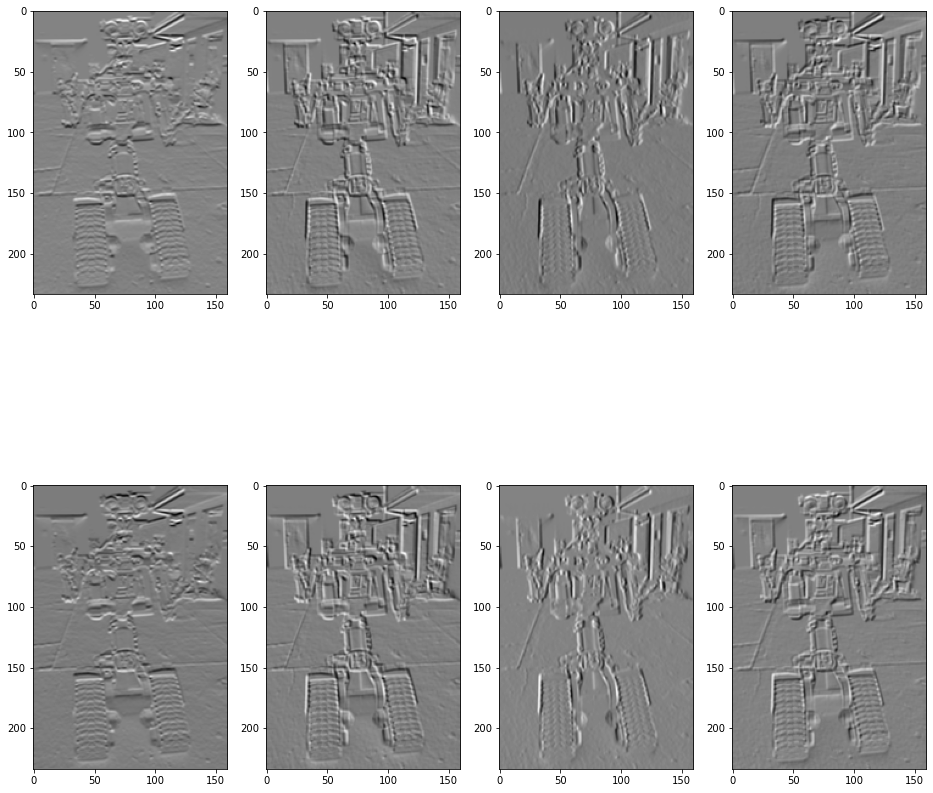

In [40]:
plt.figure(figsize=(16, 8 * (kernels_sob.shape[0] // 4)))
for i in range(kernels_sob.shape[0]):
    plt.subplot(kernels_sob.shape[0] // 4, 4, i + 1)
    plt.imshow(edges_sob_dir[..., i], cmap='gray')

In [41]:
# the result will be the max along the directions
edges_sob = edges_sob_dir.max(axis=2)
edges_dir = edges_sob_dir.argmax(axis=2)

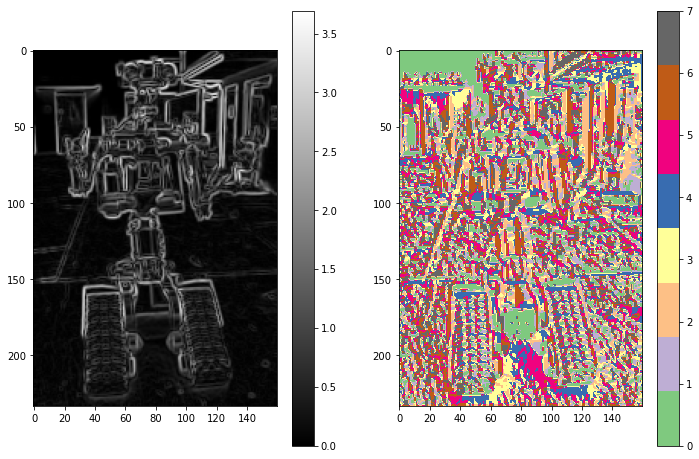

In [42]:
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.imshow(edges_sob, cmap='gray')
plt.colorbar();
plt.subplot(1, 2, 2)
plt.imshow(edges_dir, cmap='Accent')
plt.colorbar();

## Laplace

In [43]:
kernel_lap_4 = np.array(
    [
        [0, 1, 0],
        [1, -4, 1],
        [0, 1, 0]
    ],
    dtype=float
)
kernel_lap_4

array([[ 0.,  1.,  0.],
       [ 1., -4.,  1.],
       [ 0.,  1.,  0.]])

In [44]:
edges_lap_4 = cv2.filter2D(gray, -1, kernel_lap_4)
edges_lap_4.min(), edges_lap_4.max()

(-2.1750116, 1.4774)

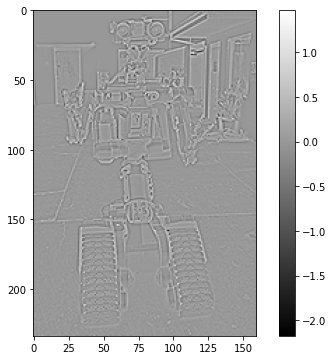

In [45]:
plt.imshow(edges_lap_4, cmap='gray')
plt.colorbar();

### All variants

In [46]:
kernels_lap = np.array(
    [
        [0, 1, 0, 1, -4, 1, 0, 1, 0],
        [1, 1, 1, 1, -8, 1, 1, 1, 1],
        [2, -1, 2, -1, -4, -1, 2, -1, 2],
        [-1, 2, -1, 2, -4, 2, -1, 2, -1]
    ],
    dtype=float
).reshape((-1, 3, 3))
kernels_lap

array([[[ 0.,  1.,  0.],
        [ 1., -4.,  1.],
        [ 0.,  1.,  0.]],

       [[ 1.,  1.,  1.],
        [ 1., -8.,  1.],
        [ 1.,  1.,  1.]],

       [[ 2., -1.,  2.],
        [-1., -4., -1.],
        [ 2., -1.,  2.]],

       [[-1.,  2., -1.],
        [ 2., -4.,  2.],
        [-1.,  2., -1.]]])

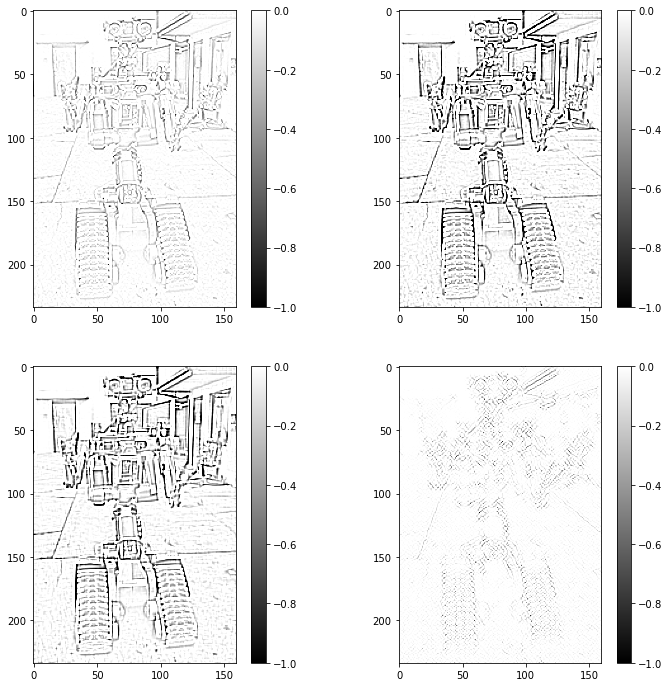

In [47]:
# reproduce image on the slide 3/25 of P05.pdf
plt.figure(figsize=(12, 12))
for i, kern in enumerate(kernels_lap):
    edges_lap = cv2.filter2D(gray, -1, kern)
#     edges_lap = signal.convolve2d(gray, kern.reshape(3, 3), mode='same', boundary='symm')
    
    plt.subplot(2, 2, i + 1)
    plt.imshow(-edges_lap, cmap='gray', vmin=-1, vmax=0)
    plt.colorbar()

### OpenCV

In [48]:
edges_lap = cv2.Laplacian(gray, -1)

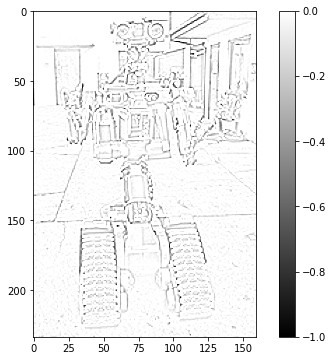

In [49]:
plt.imshow(-edges_lap, cmap='gray', vmin=-1, vmax=0)
plt.colorbar();

# Sharpening

In [50]:
sharp_lap_4 = gray - 0.3 * cv2.filter2D(gray, -1, kernels_lap[0])
sharp_lap_4 = np.clip(sharp_lap_4, 0., 1.)

In [51]:
sharp_lap_8 = gray - 0.3 * cv2.filter2D(gray, -1, kernels_lap[1])
sharp_lap_8 = np.clip(sharp_lap_8, 0., 1.)

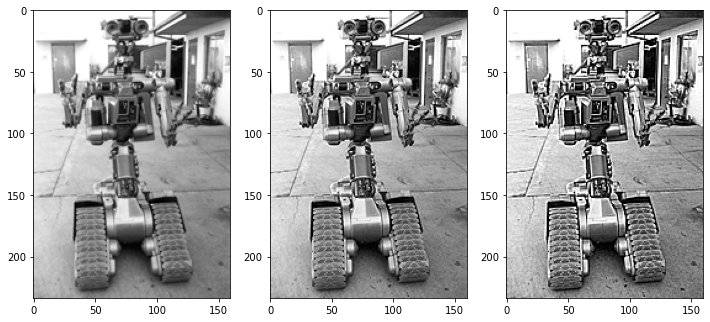

In [52]:
plt.figure(figsize=(12, 8))
plt.subplot(1, 3, 1)
plt.imshow(gray, cmap='gray', vmin=0, vmax=1);
plt.subplot(1, 3, 2)
plt.imshow(sharp_lap_4, cmap='gray', vmin=0, vmax=1);
plt.subplot(1, 3, 3)
plt.imshow(sharp_lap_8, cmap='gray', vmin=0, vmax=1);

# Unsharp masking

In [53]:
blurry = cv2.GaussianBlur(gray, (9, 9), 2.)
unsharp = np.clip(gray + 0.75 * (gray - blurry), 0., 1.)

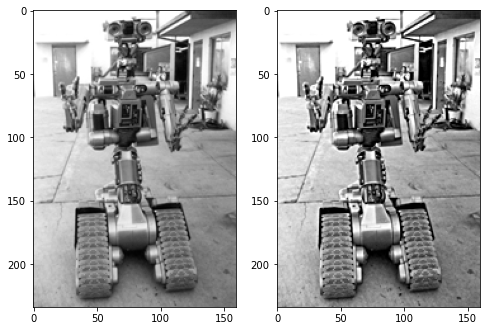

In [54]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.imshow(gray, cmap='gray', vmin=0, vmax=1);
plt.subplot(1, 2, 2)
plt.imshow(unsharp, cmap='gray', vmin=0, vmax=1);

# Canny edge detection

In [55]:
rgb = cv2.imread('./data/sudoku-original.jpg')[..., ::-1]
gray = cv2.cvtColor(rgb, cv2.COLOR_RGB2GRAY)

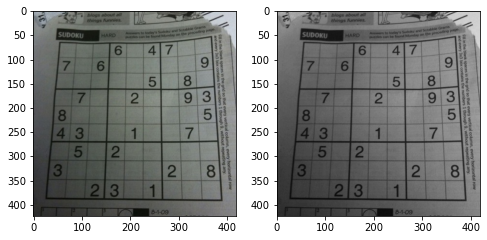

In [56]:
plt.subplot(1, 2, 1)
plt.imshow(rgb);
plt.subplot(1, 2, 2)
plt.imshow(gray, cmap='gray', vmin=0, vmax=255);

In [57]:
blurred = cv2.GaussianBlur(gray, (5, 5), 0.)

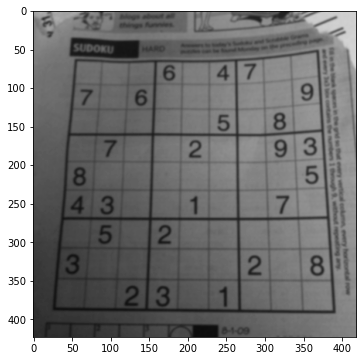

In [58]:
plt.imshow(blurred, cmap='gray', vmin=0, vmax=255);

In [59]:
edges_canny = cv2.Canny(blurred, 50, 150, 3)

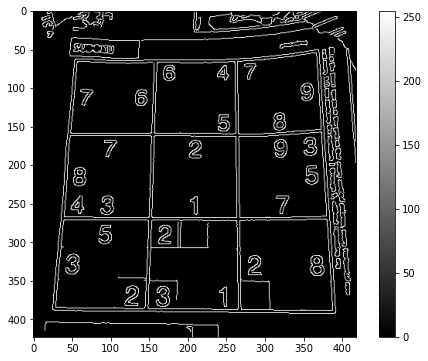

In [60]:
plt.imshow(edges_canny, cmap='gray');
plt.colorbar();

# Hough transform

In [61]:
lines = cv2.HoughLines(edges_canny, 1, np.pi/180, 150).squeeze()
lines.shape, lines

((21, 2),
 array([[ 162.   ,    0.035],
        [ 268.   ,    1.571],
        [ 271.   ,    1.571],
        [ 159.   ,    1.571],
        [  62.   ,    0.087],
        [-259.   ,    3.124],
        [-262.   ,    3.124],
        [-378.   ,    3.072],
        [  64.   ,    0.105],
        [ 159.   ,    0.035],
        ...,
        [-383.   ,    3.072],
        [  67.   ,    1.553],
        [-364.   ,    3.072],
        [ 386.   ,    1.588],
        [ 162.   ,    1.571],
        [-360.   ,    3.072],
        [ 273.   ,    1.553],
        [ 164.   ,    0.052],
        [-369.   ,    3.072],
        [-373.   ,    3.072]], dtype=float32))

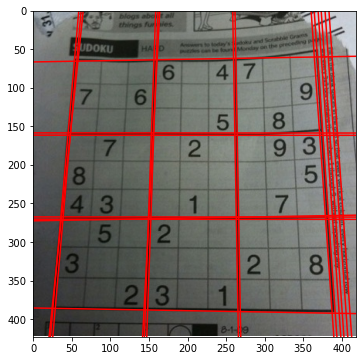

In [62]:
plt.imshow(rgb)

for rho, theta in lines:
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a * rho
    y0 = b * rho
    x1 = int(x0 + 1000*(-b))
    y1 = int(y0 + 1000*(a))
    x2 = int(x0 - 1000*(-b))
    y2 = int(y0 - 1000*(a))
    
    plt.plot((x1, x2), (y1, y2), '-r')

plt.xlim(0, rgb.shape[1]);
plt.ylim(rgb.shape[0], 0);

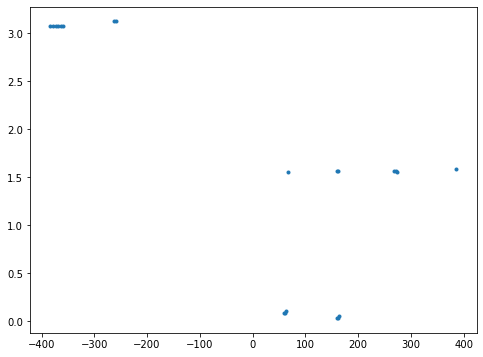

In [63]:
# show the lines as points in 2D parameter space
plt.plot(lines[:, 0], lines[:, 1], '.');

In [64]:
# axes have different units and so it is difficult to properly calculate Euclidean distance between points --> normalize by the standard deviation
std = np.std(lines, axis=0)
lines_ = lines / std

In [65]:
lines_

array([[ 0.613,  0.029],
       [ 1.014,  1.283],
       [ 1.026,  1.283],
       [ 0.602,  1.283],
       [ 0.235,  0.071],
       [-0.98 ,  2.552],
       [-0.992,  2.552],
       [-1.431,  2.509],
       [ 0.242,  0.086],
       [ 0.602,  0.029],
       ...,
       [-1.45 ,  2.509],
       [ 0.254,  1.269],
       [-1.378,  2.509],
       [ 1.461,  1.297],
       [ 0.613,  1.283],
       [-1.363,  2.509],
       [ 1.033,  1.269],
       [ 0.621,  0.043],
       [-1.397,  2.509],
       [-1.412,  2.509]], dtype=float32)

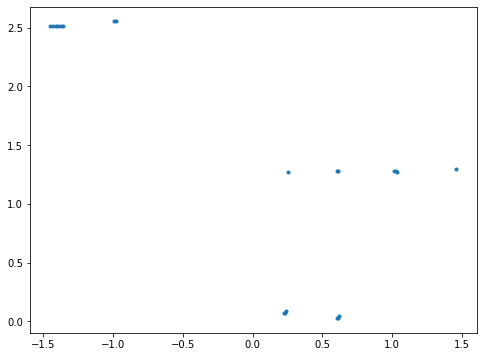

In [66]:
# show the normalized lines as points in 2D parameter space
plt.plot(lines_[:, 0], lines_[:, 1], '.');

In [67]:
# compute cluster centers
kmeans = cluster.KMeans(n_clusters=8, n_init=100, max_iter=300).fit(lines_)
kmeans.cluster_centers_

array([[ 0.233,  0.076],
       [-1.405,  2.509],
       [ 1.024,  1.278],
       [ 0.608,  1.283],
       [ 0.612,  0.033],
       [-0.986,  2.552],
       [ 1.461,  1.297],
       [ 0.254,  1.269]], dtype=float32)

In [68]:
# restore the original units
clusters = kmeans.cluster_centers_ * std

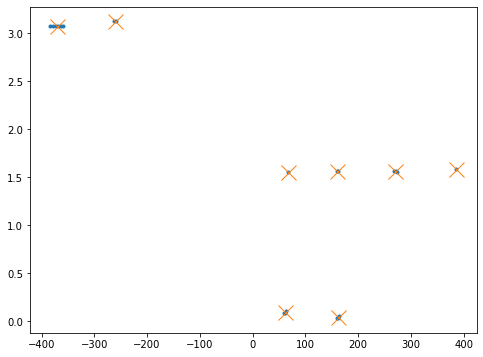

In [69]:
plt.plot(lines[:, 0], lines[:, 1], '.');
plt.plot(clusters[:, 0], clusters[:, 1], 'x', markersize=15);

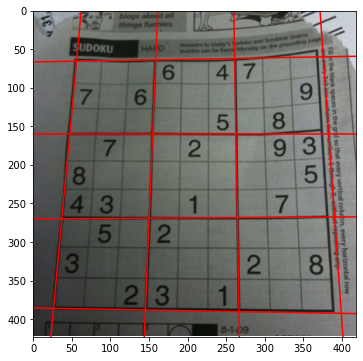

In [70]:
plt.imshow(rgb)

for rho, theta in clusters:
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a * rho
    y0 = b * rho
    x1 = int(x0 + 1000*(-b))
    y1 = int(y0 + 1000*(a))
    x2 = int(x0 - 1000*(-b))
    y2 = int(y0 - 1000*(a))
    
    plt.plot((x1, x2), (y1, y2), '-r')

plt.xlim(0, rgb.shape[1]);
plt.ylim(rgb.shape[0], 0);

# Homework: find the four corners of the Sudoku as line intersections and extract a square region of interest

The goal of the exercise is to automatically compute matrix `corners` of 4 points that correspond to positions of the Sudoku corners. The points should be in the following order: top-left, top-right, bottom-right, bottom-left. In ideal case, the matrix `corners` should be close to matrix `corners_manual` (see next cell), where we entered the correct coordinates manually.

In [71]:
# array of shape (4, 2) of four (x, y) pairs
corners_manual = np.array([
    [53, 62],    # top-left
    [365, 52],   # top-right
    [390, 390],  # bottom-right
    [25, 385]    # bottom-left
])

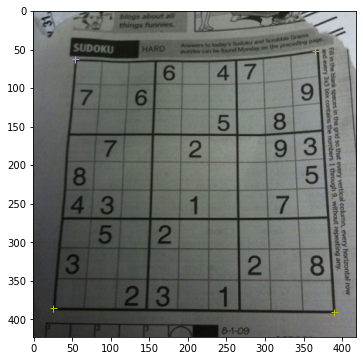

In [72]:
plt.imshow(rgb)
plt.plot(corners_manual[:, 0], corners_manual[:, 1], '+y', markersize=7);

In [73]:
# this is our input: two-column matrix of our lines, where each row is one line as a pair (offset, angle)
clusters

array([[  61.667,    0.093],
       [-371.167,    3.072],
       [ 270.667,    1.565],
       [ 160.5  ,    1.571],
       [ 161.667,    0.041],
       [-260.5  ,    3.124],
       [ 386.   ,    1.588],
       [  67.   ,    1.553]], dtype=float32)

In [74]:
len(clusters)

8

In [75]:
np.where(clusters == np.min(abs(clusters[:,0])))

(array([0], dtype=int64), array([0], dtype=int64))

In [76]:
# take the left most vertical line from the cluster
ind =np.where(clusters == np.min(abs(clusters[:,0])))
lmv = clusters[ind[0],:]
lmv_ = (lmv[0,0], lmv[0,1])

In [77]:
# take the right most vertical line from the clusters matrix
ind =np.where(clusters == np.min(clusters[:,0]))
rmv = clusters[ind[0],:]
rmv_ = (rmv[0,0], rmv[0,1])

In [78]:
# take the top most horizontal line from the clusters matrix
ind =np.where(clusters == 67)
tmh = clusters[ind[0],:]
tmh_= (tmh[0,0], tmh[0,1])

In [79]:
# take the bottom horizontal most line from the clusters matrix
ind =np.where(clusters == np.max(abs(clusters[:,0])))
bmh = clusters[ind[0],:]
bmh_ = (bmh[0,0],bmh[0,1])

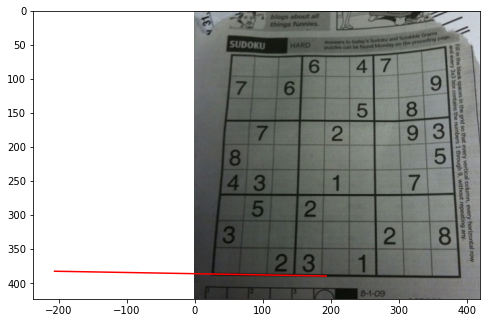

In [80]:
plt.imshow(rgb)
theta = bmh_[1]
rho =  bmh_[0]
a = np.cos(theta)
b = np.sin(theta)
x0 = a * rho
y0 = b * rho
x1 = int(x0 + 200*(-b))
y1 = int(y0 + 200*(a))
x2 = int(x0 - 200*(-b))
y2 = int(y0 - 200*(a))
    
plt.plot((x1, x2), (y1, y2), '-r')

Define a function for line-line intersection. You can calculate an intersection of two lines $(a_1, b_1, c_1)$ and $(a_2, b_2, c_2)$ in homogenous coordinates as
$$
\begin{split}
(x, y, z) & = (a_1, b_1, c_1) \times (a_2, b_2, c_2) \\
          & = (b_1c_2 - b_2c_1, a_2c_1 - a_1c_2, a_1b_2 - a_2b_1)
\end{split}
$$
where
- $\times$ denotes the [cross product](https://en.wikipedia.org/wiki/Cross_product) of the two vectors,
- $(x, y, z)$ are the unnormalized cartesian corrdinates of the intersection point. To get the final normalized 2D corrdinates $(x', y')$, divide by $z$:
$$
(x', y') = \left(\frac{x}{z}, \frac{y}{z}\right)
$$
You can use the function [`numpy.cross`](https://numpy.org/doc/stable/reference/generated/numpy.cross.html) from the numpy library for computing the cross product.

Remember that from the Hough transform and the subsequent clustering we got the lines in polar coordinates, i.e. in the form
$$
r = x \cdot \cos \theta + y \cdot \sin \theta
$$
where $r$ is the line offset and $\theta$ the line angle, see e.g. [this OpenCV example](https://docs.opencv.org/3.4/d9/db0/tutorial_hough_lines.html). So, as a first step, we need to convert the line into homogenous coordinates, where the line equation is
$$
a \cdot x + b \cdot y + c = 0
$$

In [81]:
# `tuple[float, float]` type hinting throws exception for python < 3.9
# https://stackoverflow.com/a/39458225/9418551

def line_intersect(
    line1_polar: tuple[float, float], 
    line2_polar: tuple[float, float]
) -> tuple[float, float]:
    """
    Args:
        line1: tuple (offset, angle)
        line2: tuple (offset, angle)
    Returns:
        (x, y) cartesian coordinates of the intersection point between line1 and line2
    """
    ########################################
    # TODO: implement
    a1 = np.cos(line1_polar[1])
    b1 = np.sin(line1_polar[1])
    c1 = -line1_polar[0]
    a2 = np.cos(line2_polar[1])
    b2 = np.sin(line2_polar[1])
    c2 = -line2_polar[0]
    x = np.array([a1, b1, c1])
    y = np.array([a2, b2, c2])
    xh, yh, zh = np.cross(x, y)
    x = xh/zh
    y = yh/zh
    # ENDTODO
    
    return x, y

In [82]:
# calculate the intersection of left most and top most
xtl, ytl = line_intersect(lmv_, tmh_)  # tl ... top-left
print(xtl, ytl)
# calculate the intersection of right most and top most
xtr, ytr = line_intersect(rmv_, tmh_)  # tr ... top-right
xbr, ybr = line_intersect(rmv_, bmh_)
xbl, ybl = line_intersect(lmv_, bmh_)
...

55.770008 66.036736


Ellipsis

In [83]:
# array of shape (4, 2) of four (x, y) pairs
# automatically calculated cornes from line intersections
corners = np.array([
    [xtl, ytl],  # top-left
    [xtr, ytr],  # top-right
    [xbr, ybr],  # bottom-right
    [xbl, ybl]   # bottom-left
])

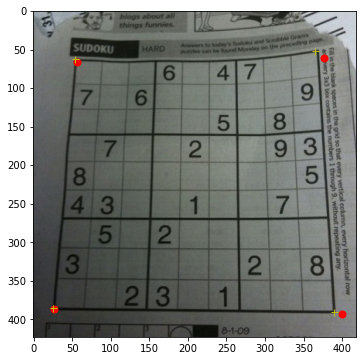

In [84]:
plt.imshow(rgb)
plt.plot(corners[:, 0], corners[:, 1], 'or', markersize=7);
plt.plot(corners_manual[:, 0], corners_manual[:, 1], '+y', markersize=7);

In [85]:
# extract region of interest from the RGB image as per geom-transform lecture
src_pts = corners = np.array([
    [xtl, ytl,1],  # top-left
    [xtr, ytr,1],  # top-right
    [xbr, ybr,1],  # bottom-right
    [xbl, ybl,1]   # bottom-left
])

# select target size (width x height)
dsize = 300, 300

# target points will be corners of the resulting image
dst_pts = np.array(
    [
        (0, 0, 1),
        (dsize[0], 0, 1),
        (dsize[0], dsize[1], 1),
        (0, dsize[1], 1)
    ],
    dtype=np.float32
)
M, mask = cv2.findHomography(src_pts, dst_pts)

roi = cv2.warpPerspective(rgb, M, dsize)

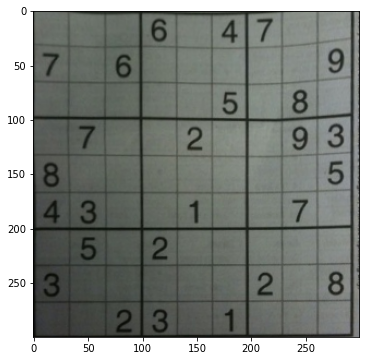

In [86]:
plt.imshow(roi);

# Hough transform for circles: Coin segmentation

In [ ]:
rgb = cv2.imread('data/water_coins.jpg')[..., ::-1]
gray = cv2.cvtColor(rgb, cv2.COLOR_RGB2GRAY)

In [ ]:
plt.subplot(1, 2, 1)
plt.imshow(rgb);
plt.subplot(1, 2, 2)
plt.imshow(gray, cmap='gray', vmin=0, vmax=255);

In [ ]:
edges_canny = cv2.Canny(gray, 80, 150)

In [ ]:
plt.imshow(edges_canny)
plt.colorbar();

In [ ]:
circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, 2, 20, param1=150, param2=50, minRadius=20, maxRadius=30)
circles.shape

In [ ]:
plt.imshow(rgb)
for xc, yc, rad in circles.squeeze():
    circ = plt.Circle((xc, yc), rad, color=(1, 0, 0), fill=False)
    plt.gca().add_artist(circ)